In [1]:
#  Install neccesary packages 
import os 
import numpy as np
import cv2 as cv
import zipfile 
from glob import glob
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from skimage.segmentation import slic
from skimage.util import img_as_float
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import random
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt 
import time 
from collections import defaultdict
!pip install kaggle

In [2]:
# Load images form Kaggle
Data_dir = "data/agropest12"
os.makedirs(Data_dir, exist_ok=True)

!kaggle datasets download -d rupankarmajumdar/crop-pests-dataset -p {Data_dir}

Dataset URL: https://www.kaggle.com/datasets/rupankarmajumdar/crop-pests-dataset
License(s): MIT
crop-pests-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip the data  from the zipfile
zip_files = glob(os.path.join(Data_dir, "*.zip"))

for z in zip_files:
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(Data_dir)

In [ ]:
# Combine image and corresponding lables 
DATA_DIR = "data/agropest12"  # transfer to directory 


train_img_dir = os.path.join(DATA_DIR, "train", "images")
train_lbl_dir = os.path.join(DATA_DIR, "train", "labels")

val_img_dir   = os.path.join(DATA_DIR, "valid", "images")
val_lbl_dir   = os.path.join(DATA_DIR, "valid", "labels")

test_img_dir  = os.path.join(DATA_DIR, "test", "images")
test_lbl_dir  = os.path.join(DATA_DIR, "test", "labels")

print("Train:", train_img_dir, train_lbl_dir)
print("Val:  ", val_img_dir,   val_lbl_dir)
print("Test: ", test_img_dir,  test_lbl_dir)

Train: data/agropest12\train\images data/agropest12\train\labels
Val:   data/agropest12\valid\images data/agropest12\valid\labels
Test:  data/agropest12\test\images data/agropest12\test\labels


In [ ]:
# building Image level dataset for general purpose testing 
def build_image_level_dataset(img_dir, lbl_dir):
    img_paths = []
    labels = []


    for img_path in glob(os.path.join(img_dir, "*.jpg")):
        base = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, base + ".txt")
        if not os.path.exists(lbl_path):
            continue

        cls_ids = []
        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 1:
                    try:
                        cls_ids.append(int(parts[0]))
                    except ValueError:
                        pass

        if not cls_ids:
            continue

        # assume single target class per image:
        uniq = sorted(set(cls_ids))
        if len(uniq) == 1:
            label = uniq[0]
        else:
            # if multiple classes appear, choose the majority class
            label = max(uniq, key=cls_ids.count)

        img_paths.append(img_path)
        labels.append(label)

    return np.array(img_paths), np.array(labels, dtype=np.int32)

# Extract values from directories 
train_paths, train_labels = build_image_level_dataset(train_img_dir, train_lbl_dir)
val_paths,   val_labels   = build_image_level_dataset(val_img_dir,   val_lbl_dir)
test_paths,  test_labels  = build_image_level_dataset(test_img_dir,  test_lbl_dir)

# Print to see if number smatch up with specs 
print("Train images:", len(train_paths))
print("Val images:  ", len(val_paths))
print("Test images: ", len(test_paths))

print("Train label dist:",
      {int(k): int(v) for k, v in zip(*np.unique(train_labels, return_counts=True))})

Train images: 11499
Val images:   1095
Test images:  546
Train label dist: {0: 1032, 1: 1101, 2: 857, 3: 906, 4: 714, 5: 942, 6: 1044, 7: 1059, 8: 797, 9: 1079, 10: 1008, 11: 960}


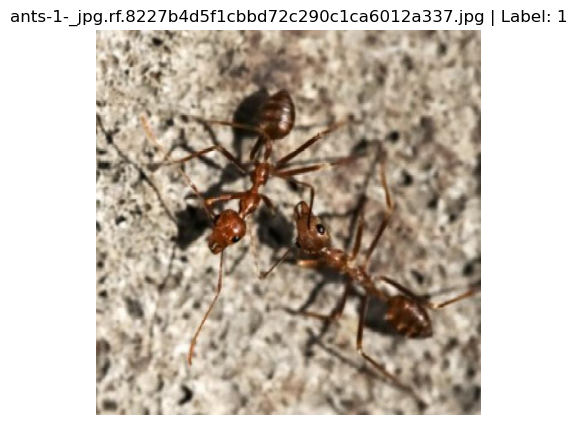

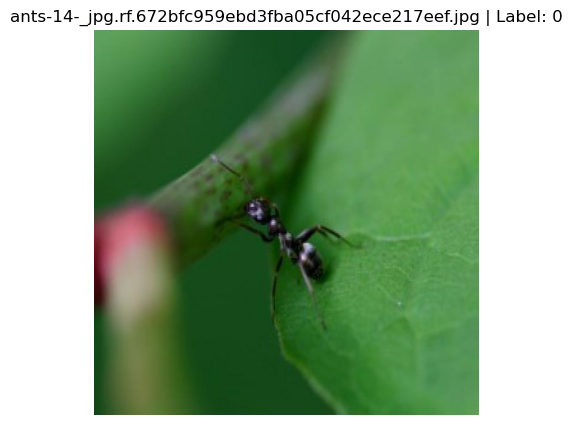

In [ ]:
# Show image level instances to see if correctly initialised 
def show_image_level(idx, img_paths, labels=None):
    img_path = img_paths[idx]
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{os.path.basename(img_path)} | Label: {labels[idx]}")

    plt.show()

# random examples
show_image_level(0, train_paths, train_labels)
show_image_level(10, val_paths, val_labels)

In [7]:
# Create crop level dataset for image training 
# Get the image shape
def load_image_size(path):
    img = cv.imread(path)
    if img is None: return None
    h, w = img.shape[:2]
    return w, h

# Convert to dimesions for image
def yolo_to_xyxy(xc, yc, bw, bh, iw, ih):
    xc, yc, bw, bh = xc*iw, yc*ih, bw*iw, bh*ih
    x1, y1 = int(round(xc - bw/2)), int(round(yc - bh/2))
    x2, y2 = int(round(xc + bw/2)), int(round(yc + bh/2))
    x1, y1 = max(0, min(x1, iw-1)), max(0, min(y1, ih-1))
    x2, y2 = max(0, min(x2, iw-1)), max(0, min(y2, ih-1))
    if x2 <= x1 or y2 <= y1: return None
    return (x1, y1, x2, y2)

# Build cropped instances of the images from bounding boxes
def build_crop_instances(images_dir, labels_dir):
    instances = []
    img_paths = sorted(glob(os.path.join(images_dir, "*.jpg")))
    for img_path in tqdm(img_paths, desc=f"{os.path.basename(os.path.dirname(images_dir))}"):
        base = os.path.splitext(os.path.basename(img_path))[0] 
        lbl_path = os.path.join(labels_dir, base + ".txt")

        if not os.path.exists(lbl_path): 
            continue

        # Get image dimesions
        size = load_image_size(img_path)
        if size is None: 
            continue
        iw, ih = size

        # Get bounding box from labels and convert to x and y coordinates
        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5: 
                    continue
                cls_id = int(parts[0])
                xc, yc, bw, bh = map(float, parts[1:])
                bbox = yolo_to_xyxy(xc, yc, bw, bh, iw, ih)
                if bbox is None: 
                    continue
                instances.append((img_path, bbox, cls_id))
    return instances

# Save all bounded images 
train_instances = build_crop_instances(train_img_dir, train_lbl_dir)
val_instances   = build_crop_instances(val_img_dir,   val_lbl_dir)
test_instances  = build_crop_instances(test_img_dir,  test_lbl_dir)

print(len(train_instances), len(val_instances), len(test_instances))


test: 100%|██████████| 546/546 [00:20<00:00, 26.56it/s]

15279 1341 689


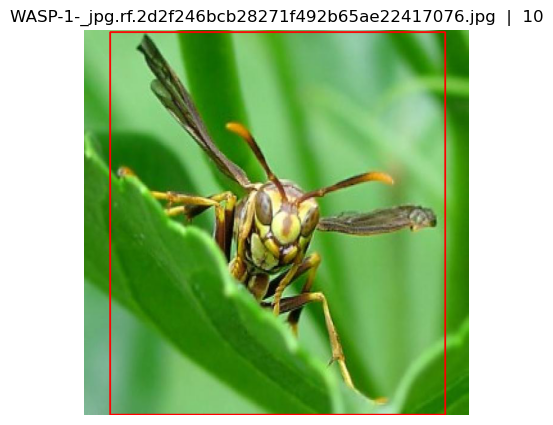

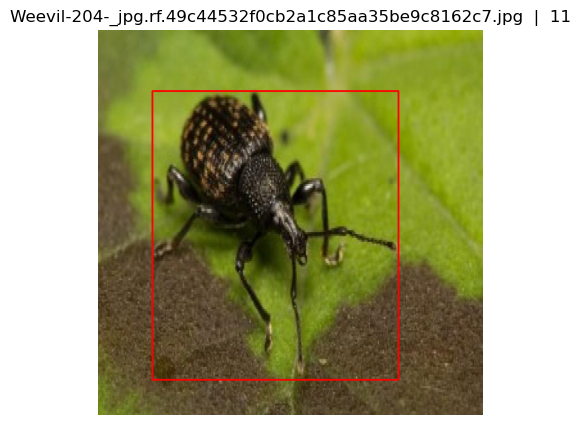

In [8]:
# Show some examples of boxed version
def show_boxed_instance(idx, instances, class_names=None):
    img_path, (x1,y1,x2,y2), cls_id = instances[idx]
    img = cv.imread(img_path)
    if img is None:
        print("Could not read:", img_path); return
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    cv.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
    label = class_names[cls_id] if class_names else str(cls_id)

    plt.figure(figsize=(5,5))
    plt.imshow(img); plt.axis("off")
    plt.title(f"{os.path.basename(img_path)}  |  {label}"); plt.show()

# examples (these use your crop-level tuples)
show_boxed_instance(0,  train_instances)
show_boxed_instance(10, test_instances)

In [ ]:
# Detect descriptors from either image or crop level datsets 
# Use one ORB across pipelines for consistency
orb = cv.ORB_create(nfeatures=1000, scaleFactor=1.2, nlevels=8,
                    edgeThreshold=31, firstLevel=0, WTA_K=2,
                    scoreType=cv.ORB_HARRIS_SCORE, patchSize=31, fastThreshold=20)

def preprocess_for_orb(gray):
    # do some local contrast for more prominenet features
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    g = clahe.apply(gray)

    # mild unsharp mask to boost edges
    blur = cv.GaussianBlur(g, (0,0), 1.0)
    sharp = cv.addWeighted(g, 1.5, blur, -0.5, 0)

    return sharp
#  Unified extractor for orb full image OR bbox 
def extract_orb(img_path, bbox=None, min_side=32):
    """
    Returns ORB descriptors for either the full image (bbox=None) or a crop (x1,y1,x2,y2).
    Upscales tiny crops so ORB can find keypoints.
    """
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        return None
    if bbox is not None:
        x1,y1,x2,y2 = bbox
        region = img[y1:y2, x1:x2]
        if region.size == 0:
            return None
        
        # Use upscaling if small reigions get found in image
        h, w = region.shape[:2]
        if min(h, w) < min_side:  
            sf = max(min_side / max(1, h), min_side / max(1, w))
            region = cv.resize(region, None, fx=sf, fy=sf, interpolation=cv.INTER_CUBIC)
    else:
        region = img

    region = preprocess_for_orb(region)
    
    kp, des = orb.detectAndCompute(region, None)
    return des  # (N, 32) or None

# BoVW histogram for region (full or crop)
def bovw_for_region(img_path, kmeans_model, k, bbox=None):
    des = extract_orb(img_path, bbox=bbox)
    if des is None or des.shape[0] == 0:
        return np.zeros(k, dtype=np.float32)
    words = kmeans_model.predict(des)
    hist = np.bincount(words, minlength=k).astype(np.float32)
    n = np.linalg.norm(hist)
    if n > 0:
        hist /= n
    return hist

# Descriptor collector that works for either cropped or full
def collect_descriptors(items, max_descriptors=50_000, per_unit_cap=400, rng_seed=39):
    rng = np.random.default_rng(rng_seed)
    buf, total = [], 0

    for item in tqdm(items, desc="Extracting descriptors"):
        if isinstance(item, (list, tuple)):  # crop-level
            img_path, bbox = item[0], item[1]
            des = extract_orb(img_path, bbox=bbox)
        else:  # image-level
            img_path = item
            des = extract_orb(img_path, bbox=None)

        if des is None or des.shape[0] == 0:
            continue
        if des.shape[0] > per_unit_cap:
            idx = rng.choice(des.shape[0], per_unit_cap, replace=False)
            des = des[idx]

        buf.append(des.astype(np.float64, copy=False))
        total += des.shape[0]
        if total >= max_descriptors:
            break

    if not buf:
        raise ValueError("No descriptors extracted.")
    desc = np.vstack(buf)
    return desc[:max_descriptors]

# Encoder that accepts cropped or full
def encode_items(items, kmeans_model, k, labels=None):
    X = np.zeros((len(items), k), dtype=np.float32)
    y = np.zeros(len(items), dtype=np.int32)

    for i, item in enumerate(tqdm(items, desc="Encoding BoVW")):
        if isinstance(item, (list, tuple)):  # crop-level
            img_path, bbox, cls_id = item
            X[i] = bovw_for_region(img_path, kmeans_model, k, bbox=bbox)
            y[i] = cls_id
        else:  # image-level
            img_path = item
            X[i] = bovw_for_region(img_path, kmeans_model, k, bbox=None)
            y[i] = labels[i] if labels is not None else -1  # -1 if unknown
    return X, y 

In [10]:
# Call the function just for Cropped for now
K = 400
# ensure max_descriptors takes values from all images 
max_descriptor = len(train_paths) * 100
# Build vocab on images
desc_crops = collect_descriptors(train_paths, max_descriptors=max_descriptor, per_unit_cap=100)
# change to float_type 64 for continouity 
desc_crops = desc_crops.astype(np.float64, copy=False)

kmeans_crop = MiniBatchKMeans(n_clusters=K, batch_size=2048, max_iter=100, random_state=39).fit(desc_crops)

# Encode crops and possibly add additional background training set 
X_train_c, y_train_c = encode_items(train_instances, kmeans_crop, K)
X_val_c,   y_val_c   = encode_items(val_instances,   kmeans_crop, K)
X_test_c,  y_test_c  = encode_items(test_instances,  kmeans_crop, K)


Extracting descriptors: 100%|██████████| 11499/11499 [03:02<00:00, 62.97it/s]
c:\Users\mario\anaconda3\envs\computer_vision\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2560 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(
Encoding BoVW: 100%|██████████| 689/689 [00:26<00:00, 26.03it/s]


In [11]:
# Get image level sets of BOW 
# image-level BoVW features
X_train_img, y_train_img = encode_items(train_paths, kmeans_crop, K, labels=train_labels)
X_val_img,   y_val_img   = encode_items (val_paths,   kmeans_crop, K, labels=val_labels)
X_test_img,  y_test_img  = encode_items(test_paths,  kmeans_crop, K, labels=test_labels)

Encoding BoVW: 100%|██████████| 546/546 [00:21<00:00, 25.39it/s]


In [12]:
# Check the shape of encoded sets 
print("Shapes:")
print("X_train_img:", X_train_img.shape, "y_train_img:", y_train_img.shape)
print("X_train_c:", X_train_c.shape, "y_train_c:", y_train_c.shape)


Shapes:
X_train_img: (11499, 400) y_train_img: (11499,)
X_train_c: (15279, 400) y_train_c: (15279,)


In [ ]:
# Train SVM model on image level data with timing 
t0 = time.perf_counter()
svm_img = SVC(kernel="rbf", C=10.0, gamma="scale", probability=True,
          class_weight='balanced', random_state=41)
svm_img.fit(X_train_img, y_train_img)
t1 = time.perf_counter()
print(f"SVM (image-level) train time: {t1 - t0:.2f}s")

SVM (image-level) train time: 243.16s


In [ ]:
# Train SVM model on crop level data with timing
t0 = time.perf_counter()
svm_c = SVC(kernel="rbf", C=10.0, gamma="scale", probability=True,
          class_weight='balanced', random_state=42)
svm_c.fit(X_train_c, y_train_c)
t1 = time.perf_counter()
print(f"SVM (crop-level) train time: {t1 - t0:.2f}s")

SVM (crop-level) train time: 416.04s


In [15]:
# Pre process images to make identification easier 
def preprocess_for_slic(img_bgr):
    # white balance images
    img = img_bgr.astype(np.float32)
    gain = img.mean(axis=(0,1), keepdims=True)
    img = img * (gain.mean() / (gain + 1e-6))
    img = np.clip(img, 0, 255).astype(np.uint8)

    # edge-preserving denoise (reduces leaf texture noise for classification)
    img = cv.bilateralFilter(img, d=7, sigmaColor=32, sigmaSpace=7)

    # gentle gamma to brighten shadows / normalize exposure
    gamma = 0.9   # brighten image a bit
    lut = np.arange(256, dtype=np.float32)
    lut = np.clip((lut/255.0) ** gamma * 255.0, 0, 255).astype(np.uint8)
    img = cv.LUT(img, lut)

    return img

In [16]:
# Now we will create a superpixel classifier to create proposals to test our ORB classification modle

# Find proposed superpixel reigons
def superpixel_proposals(img_bgr, n_segments=360, compactness=3.0,
                         min_area_frac=0.01, max_area_frac=0.3):
    h, w = img_bgr.shape[:2]

    seg = slic(img_as_float(cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)),
               n_segments=n_segments, compactness=compactness, start_label=0)
    
    # create boxes of potential objects of intrest 
    boxes, total = [], float(h*w)
    for sid in range(seg.max()+1):

        ys, xs = np.where(seg == sid)

        if xs.size == 0: continue
        x1,x2,y1,y2 = xs.min(), xs.max(), ys.min(), ys.max()

        area = (x2-x1+1)*(y2-y1+1)

        if area < min_area_frac*total or area > max_area_frac*total: continue

        boxes.append((int(x1),int(y1),int(x2),int(y2)))

    return boxes

# get the intersection over union
def iou(a,b):

    x1=max(a[0],b[0]); y1=max(a[1],b[1]); x2=min(a[2],b[2]); y2=min(a[3],b[3])

    if x2<=x1 or y2<=y1: return 0.0

    inter=(x2-x1)*(y2-y1)

    areaA=(a[2]-a[0])*(a[3]-a[1]); areaB=(b[2]-b[0])*(b[3]-b[1])
    return inter/float(areaA+areaB-inter+1e-9)

# Find the top scoring box and remover any other which overlap with it and are the same class
def nms(dets, iou_thresh=0.75):
    
    dets=sorted(dets,key=lambda d:d[5],reverse=True)
    keep=[]
    while dets:
        m=dets.pop(0); keep.append(m)
        dets=[d for d in dets if iou(d[:4], m[:4])<iou_thresh]
    return keep

def detect_superpixels(img_path, kmeans_model, svm_model, K,
                       n_segments=200, compactness=10.0,
                       prob_thresh=0.35, nms_iou=0.5, process=False, bg_label =-1):
    img_bgr = cv.imread(img_path)
    if process:
        img_bgr = preprocess_for_slic(img_bgr)
    if img_bgr is None: return []
    boxes = superpixel_proposals(img_bgr, n_segments, compactness)

    dets=[]
    for (x1,y1,x2,y2) in boxes:
        # reuse BoVW encoder 
        hist = bovw_for_region(img_path, kmeans_model, K, bbox=(x1,y1,x2,y2))
        # guard zagainst any zero vector
        if not np.any(hist): 
            continue
        probs = svm_model.predict_proba([hist])[0]
        cls = int(np.argmax(probs)); score = float(np.max(probs))
        if score < prob_thresh:
            continue

        if cls == bg_label:
            continue
        dets.append((x1,y1,x2,y2,cls,score))
    return nms(dets, iou_thresh=nms_iou)


In [17]:
# Finally we will run the entire pipeline with super pixel segmentation for segmentation 
def build_gt_dict(instances):
    gt=defaultdict(list)
    for p,(x1,y1,x2,y2),c in instances:
        gt[p].append((x1,y1,x2,y2,c))
    return gt

gt_test = build_gt_dict(test_instances)
test_image_paths = sorted(gt_test.keys())
num_classes = len(np.unique(y_train_c))

# run detector with crop-level SVM
all_preds=[]
t0=time.perf_counter()
for p in tqdm(test_image_paths, desc="Detecting (superpixels)"):
    for det in detect_superpixels(p, kmeans_crop, svm_c, K,
                                  n_segments=220, compactness=12.0,
                                  prob_thresh=0.35, nms_iou=0.65, process=True):
        all_preds.append((p, *det))
t1=time.perf_counter()
print(f"Detection inference time on test set: {t1-t0:.2f}s")

Detecting (superpixels): 100%|██████████| 546/546 [12:23<00:00,  1.36s/it]

Detection inference time on test set: 743.28s


In [18]:
# Evaluate the crop performance of the model on classification 
y_val_pred_c  = svm_c.predict(X_val_c)
y_test_pred_c = svm_c.predict(X_test_c)
print("VAL CROP:")
print(classification_report(y_val_c, y_val_pred_c, digits=3))
print("VAL acc:", accuracy_score(y_val_c, y_val_pred_c))
print("\nTEST CROP:")
print(classification_report(y_test_c, y_test_pred_c, digits=3))
print("TEST acc:", accuracy_score(y_test_c, y_test_pred_c))

VAL CROP:
              precision    recall  f1-score   support

           0      0.296     0.517     0.376       178
           1      0.312     0.264     0.286       110
           2      0.125     0.070     0.090       100
           3      0.306     0.317     0.311       139
           4      0.206     0.181     0.193        72
           5      0.260     0.192     0.221       104
           6      0.291     0.314     0.302       102
           7      0.422     0.376     0.398       101
           8      0.288     0.187     0.227        91
           9      0.394     0.364     0.379       107
          10      0.571     0.485     0.525       132
          11      0.543     0.657     0.595       105

    accuracy                          0.346      1341
   macro avg      0.335     0.327     0.325      1341
weighted avg      0.341     0.346     0.337      1341

VAL acc: 0.3460104399701715

TEST CROP:
              precision    recall  f1-score   support

           0      0.255     

In [19]:
# Evaluate image level accuracy
y_val_pred_img = svm_img.predict(X_val_img)
y_test_pred_img = svm_img.predict(X_test_img)
print("VAL IMG:")
print(classification_report(y_val_img, y_val_pred_img, digits=3))
print("VAL acc:", accuracy_score(y_val_img, y_val_pred_img))
print("\nTEST IMG:")
print(classification_report(y_test_img, y_test_pred_img, digits=3))
print("TEST acc:", accuracy_score(y_test_img, y_test_pred_img))

VAL IMG:
              precision    recall  f1-score   support

           0      0.314     0.396     0.350        96
           1      0.318     0.414     0.360        99
           2      0.200     0.114     0.145        88
           3      0.278     0.286     0.282        77
           4      0.205     0.327     0.252        52
           5      0.167     0.110     0.132        91
           6      0.277     0.316     0.295        98
           7      0.311     0.330     0.320       100
           8      0.095     0.053     0.068        76
           9      0.241     0.194     0.215        98
          10      0.400     0.379     0.389       116
          11      0.548     0.654     0.596       104

    accuracy                          0.308      1095
   macro avg      0.280     0.298     0.284      1095
weighted avg      0.291     0.308     0.295      1095

VAL acc: 0.30776255707762556

TEST IMG:
              precision    recall  f1-score   support

           0      0.327     0

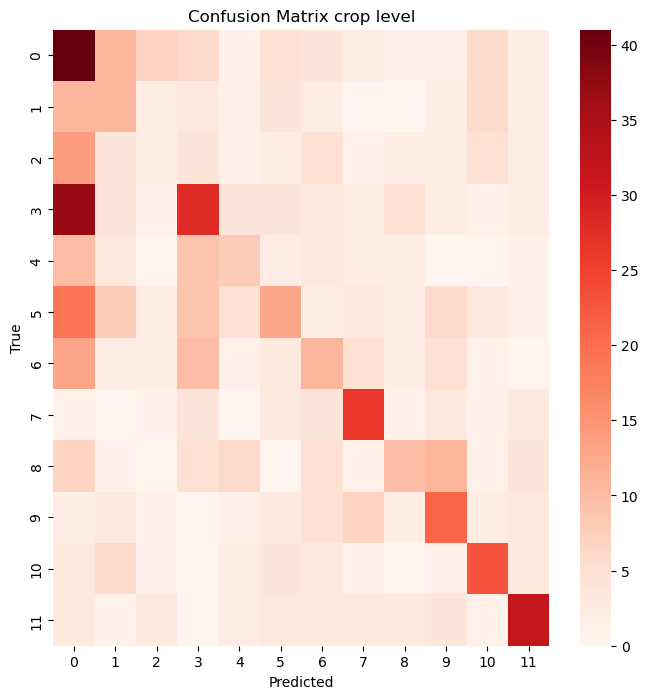

In [20]:
# Plot confusion matrix to see which classes it is getting confused on for crop images
cm_crop = confusion_matrix(y_test_c, y_test_pred_c)
classes = np.unique(y_train_c)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_crop, annot=False, cmap="Reds",
            xticklabels=range(len(classes)),
            yticklabels=range(len(classes)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix crop level")
plt.show()

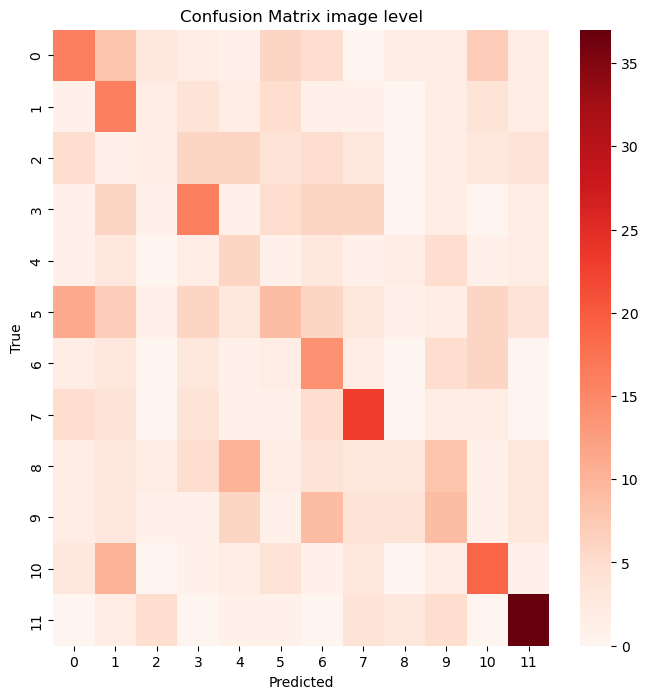

In [21]:
# Plot confusion matrix to see which classes it is getting confused on for image level images
cm_img = confusion_matrix(y_test_img, y_test_pred_img)
classes = np.unique(y_train_img)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_img, annot=False, cmap="Reds",
            xticklabels=range(len(classes)),
            yticklabels=range(len(classes)))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix image level")
plt.show()

In [ ]:
# Seem to be struggling with class 2, 4 alot in all instances, check for imbalance
def counts(y):
    unique, counts = np.unique(y, return_counts=True)
    return {int(u): int(c) for u, c in zip(unique, counts)}

print("Train", counts(y_train_c))
print("Val",   counts(y_val_c))
print("Test",  counts(y_test_c))

Train {0: 2231, 1: 1596, 2: 1058, 3: 1740, 4: 1083, 5: 1182, 6: 1071, 7: 1062, 8: 918, 9: 1196, 10: 1167, 11: 975}
Val {0: 178, 1: 110, 2: 100, 3: 139, 4: 72, 5: 104, 6: 102, 7: 101, 8: 91, 9: 107, 10: 132, 11: 105}
Test {0: 87, 1: 44, 2: 44, 3: 93, 4: 40, 5: 73, 6: 55, 7: 47, 8: 51, 9: 50, 10: 47, 11: 58}


Misclassified examples for class 2: 42


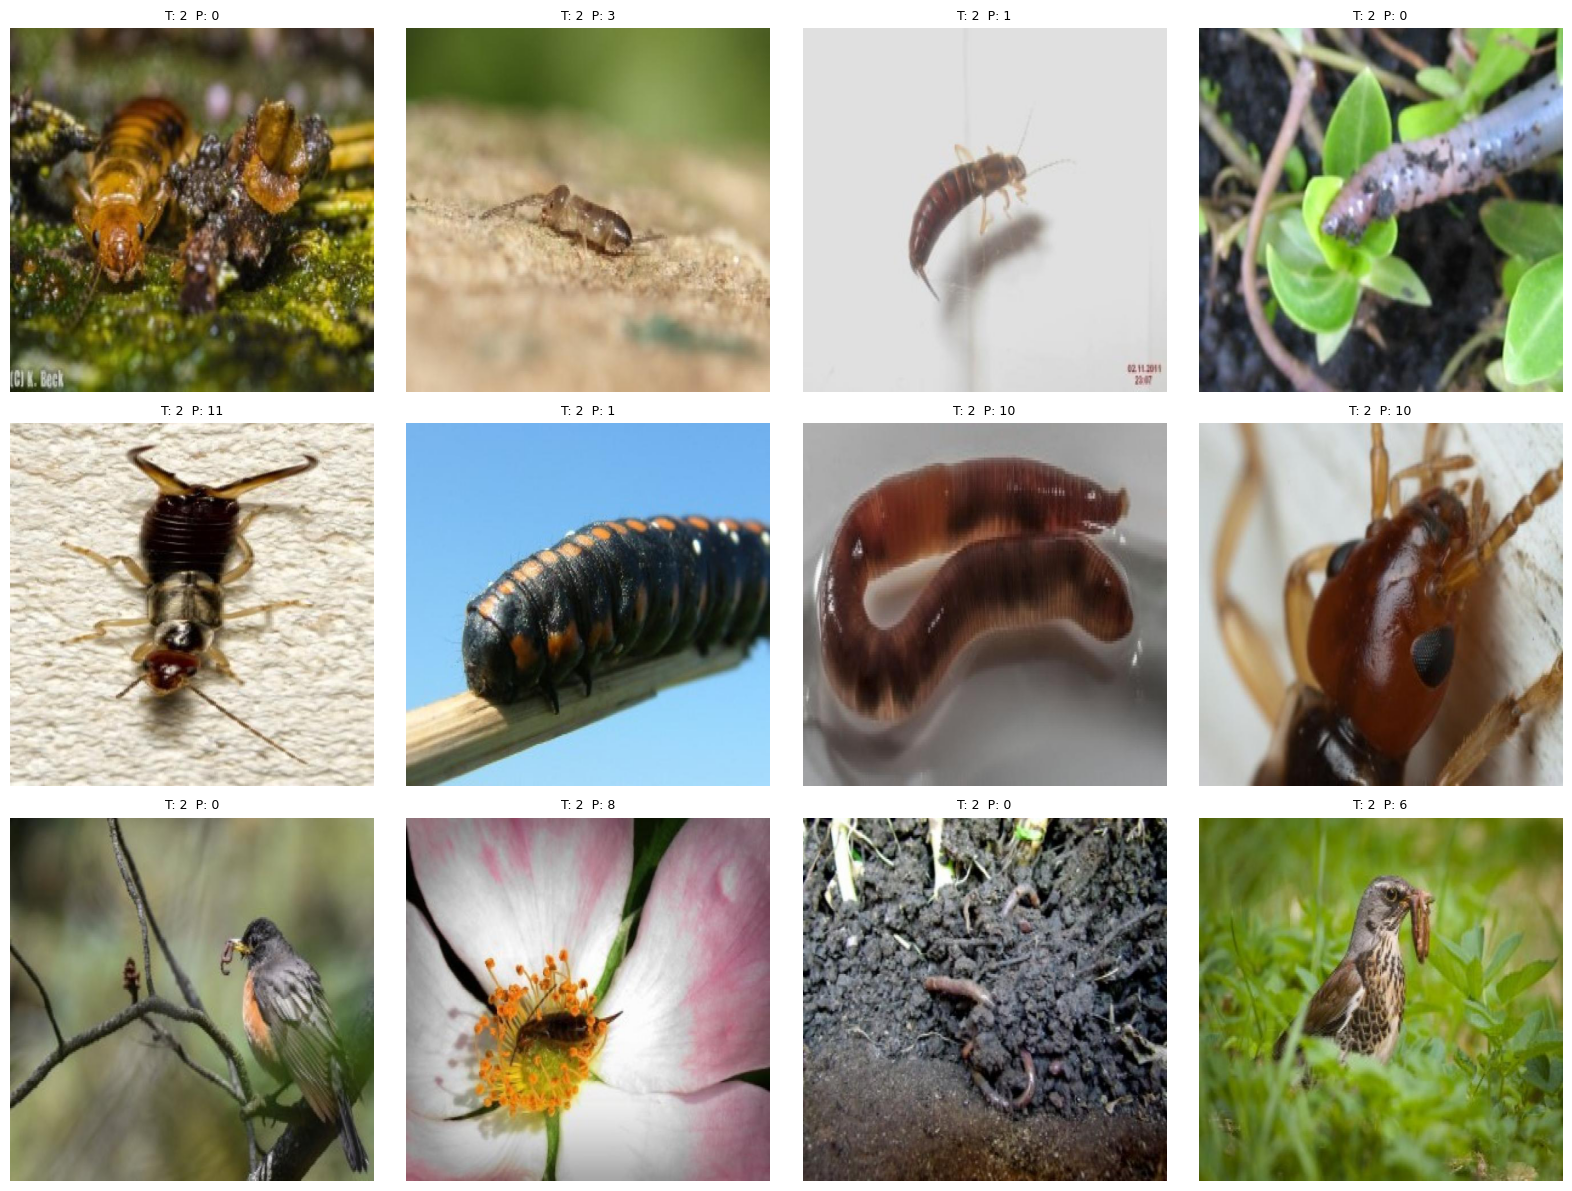

In [ ]:
# As the class balance seems fine lets visualise some examples to try and garner the issue 

def show_misclassified_examples_for_class(target_cls, img_paths, y_true, y_pred, num_examples=12):
    # indices where true is target class and predicted isnt the  target class
    idxs = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred))
            if yt == target_cls and yp != target_cls]

    print(f"Misclassified examples for class {target_cls}: {len(idxs)}")
    if not idxs:
        return

    sample = random.sample(idxs, min(num_examples, len(idxs)))

    cols = 4
    rows = int(np.ceil(len(sample) / cols))
    plt.figure(figsize=(4*cols, 4*rows))

    # Create pot to showcase multiplie examples of instances
    for j, i in enumerate(sample, 1):
        img_path = img_paths[i]
        img = cv.imread(img_path)
        if img is None:
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        yt = y_true[i]
        yp = y_pred[i]

        plt.subplot(rows, cols, j)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T: {yt}  P: {yp}", fontsize=9)

    plt.tight_layout()
    plt.show()

show_misclassified_examples_for_class(2, test_paths, y_test_c, y_test_pred_c, num_examples=12)

In [ ]:
# see if potentitally OBS is finding less diescriptors in this class comapred to others 
def avg_descriptors_per_class_croplevel(instances, class_id, max_samples=1000, seed=42):
    idxs = [i for i, (_, _, c) in enumerate(instances) if c == class_id]
    if not idxs:
        return 0.0, 0.0, 0

    rng = np.random.default_rng(seed)
    if len(idxs) > max_samples:
        idxs = rng.choice(idxs, size=max_samples, replace=False)

    counts = []
    for i in idxs:
        img_path, bbox, _ = instances[i]
        des = extract_orb(img_path, bbox=bbox)
        counts.append(0 if des is None else des.shape[0])

    return float(np.mean(counts)), float(np.median(counts)), int(len(counts))

# use this with image-level data to maximise number of potential descripotrs 
mean_0_crop, med_0_crop, n_0_crop = avg_descriptors_per_class_croplevel(test_instances, class_id=0)
print("Crop-level - Class 0 : mean kps:", mean_0_crop, "median:", med_0_crop, "samples:", n_0_crop)

mean_2_crop, med_2_crop, n_2_crop = avg_descriptors_per_class_croplevel(test_instances, class_id=2)
print("Crop-level - Class 2 : mean kps:", mean_2_crop, "median:", med_2_crop, "samples:", n_2_crop)

Crop-level - Class 0 : mean kps: 701.7931034482758 median: 819.0 samples: 87
Crop-level - Class 2 : mean kps: 751.8181818181819 median: 810.5 samples: 44


In [25]:
# Group predictions per image
def group_preds_by_image(all_preds):
    preds_by_img = defaultdict(list)
    for p, x1,y1,x2,y2,c,score in all_preds:
        preds_by_img[p].append((x1,y1,x2,y2,c,score))
    return preds_by_img

In [ ]:
# Get some per class classification numbers and corresponding metrics 
def compute_ap(rec, prec):
    # ensure sorted by recall
    order = np.argsort(rec)
    rec = rec[order]
    prec = prec[order]
    return np.trapezoid(prec, rec)  # numerical integration

def detection_map(all_preds, gt_dict, num_classes, iou_thresh=0.5):
    preds_by_img = group_preds_by_image(all_preds)

    aps = []
    ap_per_class = np.zeros(num_classes, dtype=float)

    for cls in range(num_classes):
        # collect GT boxes of this class 
        n_gt = 0
        gt_used = {} 

        for img_path, gts in gt_dict.items():
            cls_indices = [i for i,(_,_,_,_,c) in enumerate(gts) if c == cls]
            n_gt += len(cls_indices)
            gt_used[img_path] = [False] * len(gts)

        # if no gt classes
        if n_gt == 0:
            ap_per_class[cls] = np.nan
            continue  

        # collect predictions of this class
        dets = []
        for img_path, det_list in preds_by_img.items():
            for (x1,y1,x2,y2,c_pred,score) in det_list:
                if c_pred == cls:
                    dets.append((img_path, score, x1,y1,x2,y2))

        if not dets:
            ap_per_class[cls] = 0.0
            continue

        # sort by score desc
        dets.sort(key=lambda d: d[1], reverse=True)

        tps = np.zeros(len(dets), dtype=float)
        fps = np.zeros(len(dets), dtype=float)
        
        for i,(img_path, score, x1,y1,x2,y2) in enumerate(dets):
            gts = gt_dict.get(img_path, [])
            best_iou = 0.0
            best_j   = -1

            for j,(gx1,gy1,gx2,gy2,c_gt) in enumerate(gts):
                if c_gt != cls:
                    continue
                if gt_used[img_path][j]:
                    continue
                iou_val = iou((x1,y1,x2,y2), (gx1,gy1,gx2,gy2))
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_j   = j

            if best_iou >= iou_thresh and best_j != -1:
                tps[i] = 1.0
                gt_used[img_path][best_j] = True
            else:
                fps[i] = 1.0

        # cumulative TP/FP PR curve
        tps_cum = np.cumsum(tps)
        fps_cum = np.cumsum(fps)

        rec = tps_cum / float(n_gt)
        prec = tps_cum / np.maximum(tps_cum + fps_cum, 1e-9)

        ap = compute_ap(rec, prec)
        ap_per_class[cls] = ap

    # mean over classes that actually have GT
    valid = ~np.isnan(ap_per_class)
    mAP = np.mean(ap_per_class[valid]) if np.any(valid) else 0.0
    return mAP, ap_per_class 

In [ ]:
# Present results of mAP with IoU of 0.5 
mAP, ap_per_class = detection_map(all_preds, gt_test, num_classes, iou_thresh=0.5)
print(f"Detection mAP @ IoU 0.5: {mAP:.3f}")
for c, ap in enumerate(ap_per_class):
    print(f"Class {c}: AP = {ap:.3f}")

Detection mAP @ IoU 0.5: 0.002
Class 0: AP = 0.000
Class 1: AP = 0.000
Class 2: AP = 0.000
Class 3: AP = 0.001
Class 4: AP = 0.000
Class 5: AP = 0.000
Class 6: AP = 0.000
Class 7: AP = 0.000
Class 8: AP = 0.000
Class 9: AP = 0.020
Class 10: AP = 0.000
Class 11: AP = 0.000


In [ ]:
# Check Gt and detection counts to see if imbalanced detection results or if other cause  
print("GT object counts by class:")
gt_counts = np.zeros(num_classes, dtype=int)
for img, gts in gt_test.items():
    for *bbox, c in gts:
        gt_counts[c] += 1
print(gt_counts)

print("Detection counts by class:")
det_counts = np.zeros(num_classes, dtype=int)
for p, x1,y1,x2,y2,c,score in all_preds:
    det_counts[c] += 1
print(det_counts)

GT object counts by class:
[87 44 44 93 40 73 55 47 51 50 47 58]
Detection counts by class:
[773 164  13 612 185   4   2   0  30   2   4   0]


In [ ]:
# Check if it comes from localisation errors 
def localisation_recall(all_preds, gt_dict, iou_thresh=0.5):
    preds_by_img = group_preds_by_image(all_preds)

    total_gt = 0
    hit_gt   = 0

    for img, gts in gt_dict.items():
        total_gt += len(gts)
        preds = preds_by_img.get(img, [])

        for (gx1,gy1,gx2,gy2,c_gt) in gts:
            hit = False
            for (x1,y1,x2,y2,c_pred,score) in preds:
                if iou((x1,y1,x2,y2), (gx1,gy1,gx2,gy2)) >= iou_thresh:
                    hit = True
                    break
            if hit:
                hit_gt += 1

    return hit_gt / max(total_gt, 1)

loc_rec = localisation_recall(all_preds, gt_test, iou_thresh=0.5)
print(f"Localisation recall with an IoU 0.5: {loc_rec:.3f}")

Localisation recall with an IoU 0.5: 0.019


In [30]:
# Let's see if loosening the iou threshold will lead to better results 
mAP_03, _ = detection_map(all_preds, gt_test, num_classes, iou_thresh=0.3)
print(f"Detection mAP @ IoU 0.3: {mAP_03:.3f}")
loc_rec_03 = localisation_recall(all_preds, gt_test, iou_thresh=0.3)
print(f"Localisation recall @ IoU 0.3: {loc_rec_03:.3f}")

Detection mAP @ IoU 0.3: 0.002
Localisation recall @ IoU 0.3: 0.057


In [ ]:
# Getting classification metrics 
y_test_proba = svm_c.predict_proba(X_test_c)
num_classes = y_test_proba.shape[1]

# binarise true labels for auc calculation
y_test_bin = label_binarize(y_test_c, classes=range(num_classes))

# Calculate area under curve
auc_macro = roc_auc_score(
    y_test_bin, y_test_proba,
    average="macro",
    multi_class="ovr"
)
print(f"Test macro AUC (OvR): {auc_macro:.3f}")

Test macro AUC (OvR): 0.777


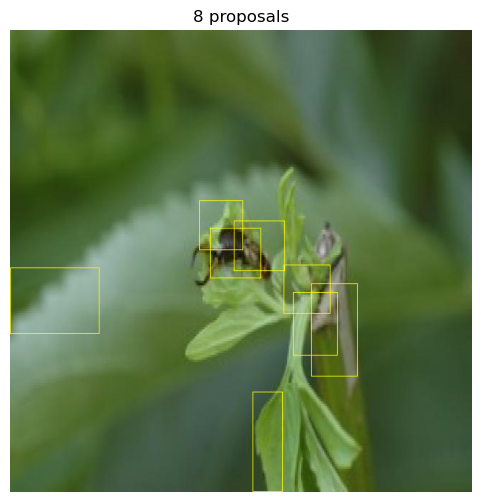

In [ ]:
# Investigate the proposals to see where the issues and misclassifications arise 
def show_proposals(img_path, n_segments=220, compactness=13.5, min_area_frac=0.01, max_area_frac=0.6, max_show=200):
    
    img = cv.imread(img_path); h,w = img.shape[:2]

    boxes = superpixel_proposals(img, n_segments, compactness, min_area_frac, max_area_frac)

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # Draw boxes to corresponding super pixel propositions 
    for (x1,y1,x2,y2) in boxes[:max_show]:
        cv.rectangle(img, (x1,y1), (x2,y2), (255,255,0), 1)  # use yellow for proposols
    plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis("off")
    plt.title(f"{len(boxes)} proposals"); plt.show()
    return boxes

# pick a test image and show its bounding boxes as found by super pixel
sample = test_image_paths[301]
props = show_proposals(sample, n_segments=440, compactness=10.0)

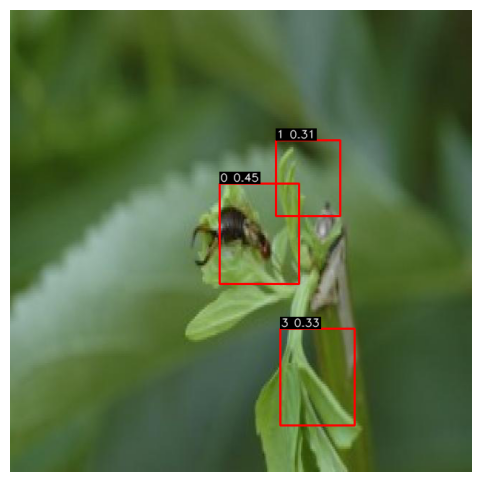

In [ ]:
# See how bounding boxes were being classified 

def show_dets(img_path, dets, class_names=None, max_show=30):
    img = cv.imread(img_path)

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    for (x1,y1,x2,y2,cls,score) in dets[:max_show]:
        cv.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
        label = class_names[cls] if class_names else str(cls)
        text  = f"{label} {score:.2f}"
        # background for legibility
        (tw, th), _ = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv.rectangle(img, (x1, max(0,y1- th - 4)), (x1 + tw + 2, y1), (0,0,0), -1)
        cv.putText(img, text, (x1+1, y1-3), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv.LINE_AA)
    plt.figure(figsize=(6,6)); plt.imshow(img); plt.axis("off"); plt.show()

dets = detect_superpixels(sample, kmeans_crop, svm_c, K, n_segments=220, compactness=8.0, prob_thresh=0.30, nms_iou=0.75)
show_dets(sample, dets)

In [ ]:
# Generate negative (background) samples to train the model on false negatives to stop classifying the background
def generate_negative_samples(instances, img_dir, num_negatives_per_image=1, 
                              min_size=30, max_size=200, iou_thresh=0.1, 
                              seed=42):

    rng = np.random.default_rng(seed)
    
    # Group GT boxes by image
    gt_by_img = defaultdict(list)
    for img_path, bbox, cls_id in instances:
        gt_by_img[img_path].append(bbox)
    
    negative_samples = []
    
    # 
    for img_path in tqdm(gt_by_img.keys(), desc="Generating negatives"):
        img = cv.imread(img_path)
        if img is None:
            continue
        h, w = img.shape[:2]
        
        gt_boxes = gt_by_img[img_path]
        
        attempts = 0
        max_attempts = num_negatives_per_image * 10
        negatives_added = 0
        
        while negatives_added < num_negatives_per_image and attempts < max_attempts:
            attempts += 1
            
            # Random box size
            bw = rng.integers(min_size, min(max_size, w) + 1)
            bh = rng.integers(min_size, min(max_size, h) + 1)
            
            # Random position
            x1 = rng.integers(0, max(1, w - bw + 1))
            y1 = rng.integers(0, max(1, h - bh + 1))
            x2 = min(x1 + bw, w - 1)
            y2 = min(y1 + bh, h - 1)
            
            bbox = (x1, y1, x2, y2)
            
            # Check IoU with all GT boxes if any hits break loop don't use this box
            overlaps_gt = False
            for gt_box in gt_boxes:
                if iou(bbox, gt_box) > iou_thresh:
                    overlaps_gt = True
                    break
            
            if not overlaps_gt:
                negative_samples.append((img_path, bbox, -1))  # -1 = background class
                negatives_added += 1
    
    return negative_samples

# Cap negatives to a fraction of positives per split
MAX_NEG = 0.5  # fraction

train_neg = generate_negative_samples(train_instances, train_img_dir, num_negatives_per_image=2, seed=42)
val_neg   = generate_negative_samples(val_instances,   val_img_dir,   num_negatives_per_image=2, seed=43)
test_neg  = generate_negative_samples(test_instances,  test_img_dir,  num_negatives_per_image=2, seed=44)

# Cap to fraction of positives
train_instances_with_neg = train_instances + train_neg[:max(1, int(len(train_instances) * MAX_NEG))]
val_instances_with_neg   = val_instances   + val_neg[:max(1, int(len(val_instances) * MAX_NEG))]
test_instances_with_neg  = test_instances  + test_neg[:max(1, int(len(test_instances) * MAX_NEG))]

print(f"Train: {len(train_instances)} positives + {len(train_instances_with_neg) - len(train_instances)} negatives = {len(train_instances_with_neg)} total")
print(f"Val:   {len(val_instances)} positives + {len(val_instances_with_neg) - len(val_instances)} negatives = {len(val_instances_with_neg)} total")
print(f"Test:  {len(test_instances)} positives + {len(test_instances_with_neg) - len(test_instances)} negatives = {len(test_instances_with_neg)} total")

In [36]:
# Re-encode datasets with negative samples included
# This creates augmented feature sets that include the background class fo better
X_train_c_neg, y_train_c_neg = encode_items(train_instances_with_neg, kmeans_crop, K)
X_val_c_neg,   y_val_c_neg   = encode_items(val_instances_with_neg,   kmeans_crop, K)
X_test_c_neg,  y_test_c_neg  = encode_items(test_instances_with_neg,  kmeans_crop, K)


Encoding BoVW: 100%|██████████| 689/689 [00:10<00:00, 65.42it/s] 


In [37]:
# Train and fit the svm model 
classes = np.unique(y_train_c_neg)        # includes -1 for background
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_c_neg
)
class_weights = {int(c): float(w) for c, w in zip(classes, class_weights_arr)}
# expect low weights for negative class
print("Class weights:", class_weights)

svm_bg = SVC(
    kernel="rbf",
    C=10.0,
    gamma="scale",
    probability=True,
    class_weight='balanced', 
    random_state=38,
)
t0 = time.perf_counter()
svm_bg.fit(X_train_c_neg, y_train_c_neg)
t1 = time.perf_counter()

print(f"SVM training time (with negatives): {t1 - t0:.2f} seconds")


Class weights: {-1: 0.2307793005528311, 0: 0.7901941178498776, 1: 1.1045883940620782, 2: 1.6662789006834375, 3: 1.0131741821396993, 4: 1.6278144754599049, 5: 1.4914746843680853, 6: 1.6460532931121166, 7: 1.6600028972910328, 8: 1.9203955086308027, 9: 1.4740159506045794, 10: 1.5106453101311712, 11: 1.8081262327416174}
SVM training time (with negatives): 2743.80 seconds


In [38]:
# use alterd detectpixels to ignore labels of class -1 
all_preds = []
t0 = time.perf_counter()
for p in tqdm(test_image_paths, desc="Detecting (superpixels)"):
    for det in detect_superpixels(p, kmeans_crop, svm_bg, K,
                                  n_segments=220, compactness=12.0,
                                  prob_thresh=0.40, nms_iou=0.5, process=True,
                                  bg_label=-1):
        all_preds.append((p, *det))
t1 = time.perf_counter()
print(f"Detection inference time on test set: {t1-t0:.2f}s")

Detecting (superpixels): 100%|██████████| 546/546 [27:20<00:00,  3.01s/it]  

Detection inference time on test set: 1640.98s


In [39]:
# Evaluate crop-level classification metrics with negatives
y_val_pred_c_neg  = svm_bg.predict(X_val_c_neg)
y_test_pred_c_neg = svm_bg.predict(X_test_c_neg)
print("VAL CROP (with negatives):")
print(classification_report(y_val_c_neg, y_val_pred_c_neg, digits=3, zero_division=0))
print("VAL acc:", accuracy_score(y_val_c_neg, y_val_pred_c_neg))
print("\nTEST CROP (with negatives):")
print(classification_report(y_test_c_neg, y_test_pred_c_neg, digits=3, zero_division=0))
print("TEST acc:", accuracy_score(y_test_c_neg, y_test_pred_c_neg))

VAL CROP (with negatives):
              precision    recall  f1-score   support

          -1      0.000     0.000     0.000         0
           0      0.311     0.281     0.295       178
           1      0.353     0.273     0.308       110
           2      0.127     0.070     0.090       100
           3      0.312     0.180     0.228       139
           4      0.216     0.153     0.179        72
           5      0.280     0.202     0.235       104
           6      0.294     0.314     0.303       102
           7      0.413     0.376     0.394       101
           8      0.267     0.176     0.212        91
           9      0.390     0.364     0.377       107
          10      0.582     0.485     0.529       132
          11      0.540     0.638     0.585       105

    accuracy                          0.298      1341
   macro avg      0.314     0.270     0.287      1341
weighted avg      0.348     0.298     0.318      1341

VAL acc: 0.29828486204325133

TEST CROP (with negati

In [40]:
# Compute detection metrics for negatives model
mAP_neg, ap_per_class_neg = detection_map(all_preds, gt_test, num_classes, iou_thresh=0.5)
print(f"Detection mAP @ IoU 0.5 (with negatives): {mAP_neg:.3f}")
for c, ap in enumerate(ap_per_class_neg):
    print(f"Class {c}: AP = {ap:.3f}")

Detection mAP @ IoU 0.5 (with negatives): 0.000
Class 0: AP = 0.000
Class 1: AP = 0.000
Class 2: AP = 0.000
Class 3: AP = 0.000
Class 4: AP = 0.000
Class 5: AP = 0.000
Class 6: AP = 0.000
Class 7: AP = 0.000
Class 8: AP = 0.000
Class 9: AP = 0.000
Class 10: AP = 0.000
Class 11: AP = 0.000

Class 0: AP = 0.000
Class 1: AP = 0.000
Class 2: AP = 0.000
Class 3: AP = 0.000
Class 4: AP = 0.000
Class 5: AP = 0.000
Class 6: AP = 0.000
Class 7: AP = 0.000
Class 8: AP = 0.000
Class 9: AP = 0.000
Class 10: AP = 0.000
Class 11: AP = 0.000


Comparing detections on: earwig-311-_jpg.rf.3f2cb482534fa87f0668a8dff60c51f5.jpg


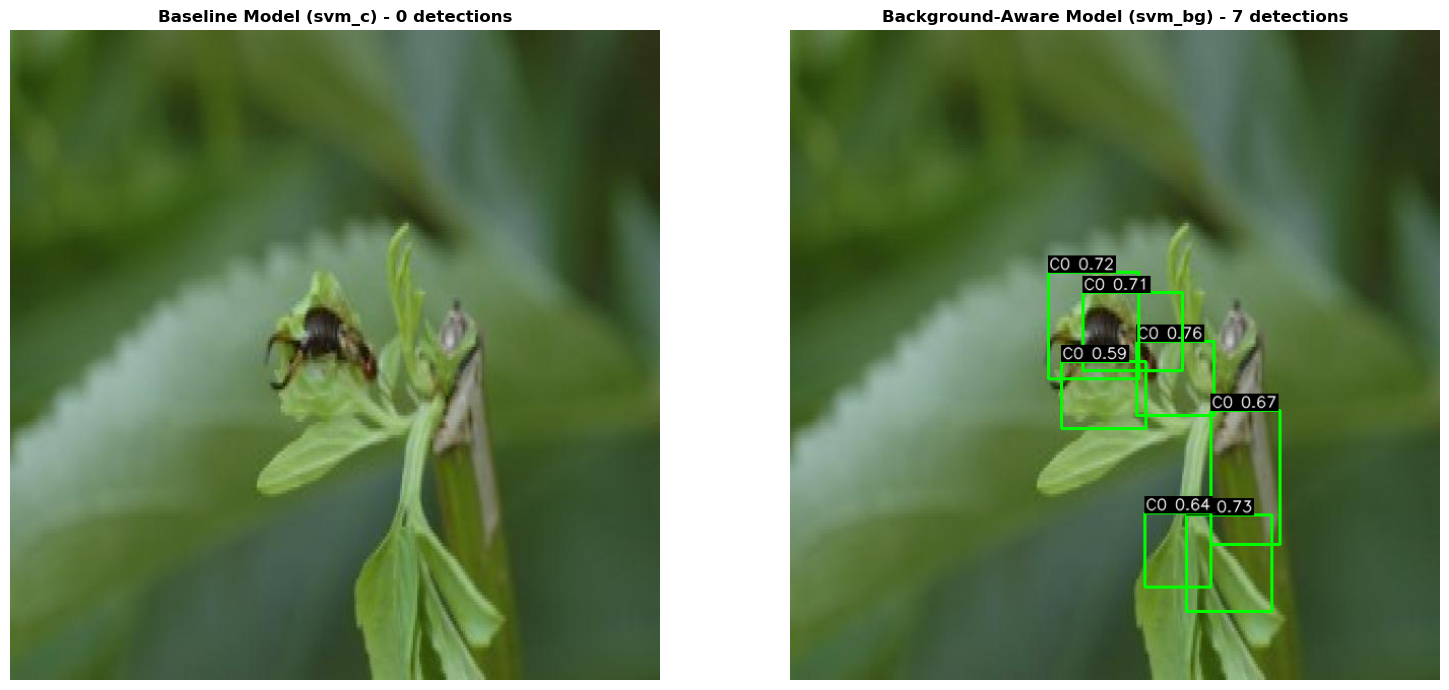

In [54]:
# Visual comparison baseline vs background-Aware Model on actual image classification boxes
def show_comparison_dets(img_path, kmeans_model, svm_baseline, svm_with_bg, K,
                         n_segments=220, compactness=8.0, prob_thresh_baseline=0.35,
                         prob_thresh_bg=0.80, nms_iou=0.75):
    # Get detections from both models
    dets_baseline = detect_superpixels(img_path, kmeans_model, svm_baseline, K,
                                       n_segments=n_segments, compactness=compactness,
                                       prob_thresh=prob_thresh_baseline, nms_iou=nms_iou,
                                       process=True, bg_label=-1)
    
    dets_bg = detect_superpixels(img_path, kmeans_model, svm_with_bg, K,
                                 n_segments=n_segments, compactness=compactness,
                                 prob_thresh=prob_thresh_bg, nms_iou=nms_iou,
                                 process=True, bg_label=-1)
    
    
    img = cv.imread(img_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # Create figure with two subplots for comparing differing pipelines
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Draw baseline detections (blue boxes)
    img_baseline = img_rgb.copy()
    for (x1, y1, x2, y2, cls, score) in dets_baseline:
        cv.rectangle(img_baseline, (x1, y1), (x2, y2), (0, 0, 255), 2)  
        text = f"C{cls} {score:.2f}"
        (tw, th), _ = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv.rectangle(img_baseline, (x1, max(0, y1 - th - 4)), (x1 + tw + 2, y1), (0, 0, 0), -1)
        cv.putText(img_baseline, text, (x1 + 1, y1 - 3), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv.LINE_AA)
    
    ax1.imshow(img_baseline)
    ax1.axis('off')
    ax1.set_title(f'Baseline Model (svm_c) - {len(dets_baseline)} detections', fontsize=12, fontweight='bold')
    
    # Draw background-aware detections (green boxes)
    img_bg = img_rgb.copy()
    for (x1, y1, x2, y2, cls, score) in dets_bg:
        cv.rectangle(img_bg, (x1, y1), (x2, y2), (0, 255, 0), 2)  
        text = f"C{cls} {score:.2f}"
        (tw, th), _ = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv.rectangle(img_bg, (x1, max(0, y1 - th - 4)), (x1 + tw + 2, y1), (0, 0, 0), -1)
        cv.putText(img_bg, text, (x1 + 1, y1 - 3), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv.LINE_AA)
    
    ax2.imshow(img_bg)
    ax2.axis('off')
    ax2.set_title(f'Background-Aware Model (svm_bg) - {len(dets_bg)} detections', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return dets_baseline, dets_bg

# Test on different images - change sample_idx to see different results
sample_idx = 301
sample = test_image_paths[sample_idx]
print(f"Comparing detections on: {os.path.basename(sample)}")
dets_base, dets_bg_model = show_comparison_dets(sample, kmeans_crop, svm_c, svm_bg, K,
                                                 n_segments=330, compactness=8.0,
                                                 prob_thresh_baseline=0.35, prob_thresh_bg=0.40)